<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 📈 Analyse statistique / Recettes / Long-Terme

In [1]:
import sys
sys.path.append('../../')

# Imports de modules personnalisés
from _data_utils import *

# Imports standards
import warnings
import importlib

# Imports data science
import polars as pl
import numpy as np

# Imports visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Imports statistiques
from scipy import stats
from scipy.stats import (
    spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest,
    shapiro, normaltest, rankdata, pearsonr
)

# Imports machine learning
from sklearn.linear_model import LinearRegression, TheilSenRegressor

# Imports statsmodels
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Imports typing
from typing import Dict, List, Tuple, Optional
from configparser import ConfigParser

# Configuration
warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ _data_utils module chargé (common + ratings + recipes)
✅ Import réussi !


## 📥 Chargement des données

In [2]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes(save_to_s3=False) # True pour enregistrer le ficher final_recipes.parquet

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

1️⃣ Chargement des données brutes...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Recettes chargées depuis S3 : 231,637 lignes × 12 colonnes

2️⃣ Nettoyage des données...
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)

3️⃣ Enrichissement des features...
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

✅ Pipeline complet terminé !
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...

📋 RAPPORT DE QUALITÉ - RAW_RECIPES
📦 Dimensions : 200,066 lignes × 28 colonnes
🔄 Doublons : 0
⚠️  Valeurs nulles :
   • description: 3,770 (1.9%)
   • description_length: 3,770 (1.9%)
⏱️ Minutes : médiane=35, moyenne=42.4, max=180
🔜 Steps : médiane=8, moyenne=9.2, max=24
🥕 I

## Analyse statistique des recettes postées

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

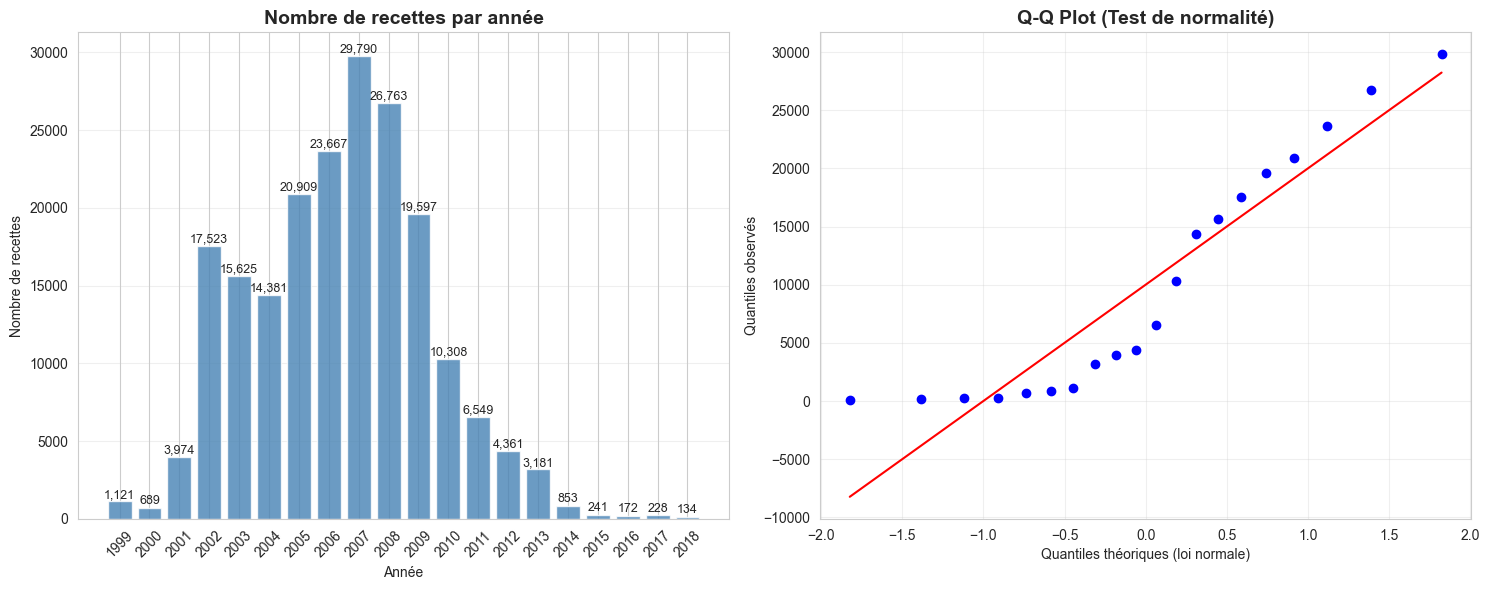

In [3]:
# 📊 ANALYSE DU NOMBRE DE RECETTES PAR ANNÉE (100% POLARS)
recipes_per_year = df.group_by("year").agg(pl.len().alias("n_recipes")).sort("year")

# Préparation des données pour le Q-Q plot
data = recipes_per_year["n_recipes"].to_numpy()
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)

# --- VISUALISATION : Fréquence + Q-Q Plot ---
fig, (ax1, ax0) = plt.subplots(1, 2, figsize=(15, 6))

# (1) Graphique de fréquence (barres)
bars = ax1.bar(recipes_per_year["year"].to_numpy().astype(int), recipes_per_year["n_recipes"].to_numpy(),
               color="steelblue", alpha=0.8)
ax1.set_title("Nombre de recettes par année", fontsize=14, fontweight="bold")
ax1.set_xlabel("Année")
ax1.set_ylabel("Nombre de recettes")
ax1.set_xticks(recipes_per_year["year"].to_numpy().astype(int))
ax1.set_xticklabels(recipes_per_year["year"].to_numpy().astype(int), rotation=45)
ax1.grid(axis="y", alpha=0.3)

# Annotations des valeurs
for x, y in zip(recipes_per_year["year"].to_numpy(), recipes_per_year["n_recipes"].to_numpy()):
    ax1.text(x, y + 50, f"{y:,}", ha="center", va="bottom", fontsize=9)

# (2) Q-Q Plot (test de normalité)
stats.probplot(data, dist="norm", plot=ax0)
ax0.set_title("Q-Q Plot (Test de normalité)", fontsize=14, fontweight="bold")
ax0.set_xlabel("Quantiles théoriques (loi normale)")
ax0.set_ylabel("Quantiles observés")
ax0.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [4]:
# 📊 TESTS DE NORMALITÉ - NOMBRE DE RECETTES PAR ANNÉE (100% POLARS)
data = recipes_per_year["n_recipes"].to_numpy()
n = len(data)
mean_data = np.mean(data)
std_data = np.std(data, ddof=1)

# --- TESTS STATISTIQUES DE NORMALITÉ ---
print("="*80)
print("📊 TESTS DE NORMALITÉ - NOMBRE DE RECETTES PAR ANNÉE")
print("="*80)

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(data)
print(f"\n1️⃣ TEST DE SHAPIRO-WILK :")
print(f"   • Statistique W      : {shapiro_stat:.6f}")
print(f"   • p-value            : {shapiro_p:.6f}")
print(f"   • Résultat           : {'✅ NORMAL' if shapiro_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")

# Test de D'Agostino-Pearson
dagostino_stat, dagostino_p = normaltest(data)
print(f"\n2️⃣ TEST DE D'AGOSTINO-PEARSON :")
print(f"   • Statistique K²     : {dagostino_stat:.6f}")
print(f"   • p-value            : {dagostino_p:.6f}")
print(f"   • Résultat           : {'✅ NORMAL' if dagostino_p > 0.05 else '❌ NON NORMAL'} (α = 0.05)")

# Statistiques descriptives
print(f"\n3️⃣ STATISTIQUES DESCRIPTIVES :")
print(f"   • Moyenne            : {mean_data:.2f}")
print(f"   • Écart-type         : {std_data:.2f}")
print(f"   • Coefficient variation : {(std_data/mean_data)*100:.1f}%")
print(f"   • Médiane            : {np.median(data):.0f}")
print(f"   • Min - Max          : {data.min():.0f} - {data.max():.0f}")

print("\n" + "="*80)

📊 TESTS DE NORMALITÉ - NOMBRE DE RECETTES PAR ANNÉE

1️⃣ TEST DE SHAPIRO-WILK :
   • Statistique W      : 0.861946
   • p-value            : 0.008508
   • Résultat           : ❌ NON NORMAL (α = 0.05)

2️⃣ TEST DE D'AGOSTINO-PEARSON :
   • Statistique K²     : 3.532839
   • p-value            : 0.170944
   • Résultat           : ✅ NORMAL (α = 0.05)

3️⃣ STATISTIQUES DESCRIPTIVES :
   • Moyenne            : 10003.30
   • Écart-type         : 10100.64
   • Coefficient variation : 101.0%
   • Médiane            : 5455
   • Min - Max          : 134 - 29790



#### Interprétation

> **💡 Interprétation:** 
>
> Nous observons une **forte augmentation du nombre de recettes postées jusqu’en 2007**, année du **pic d’activité**, suivie d’une **chute marquée** les années suivantes. 
>
> Les **tests de normalité** et les **Q-Q plots** montrent que la distribution du **nombre de recettes par an** **n’est pas parfaitement normale**, avec des **écarts visibles** par rapport à la **loi normale théorique**. 
>    

### Analyse 2: Évolution de la durée moyenne
#### Visualisation

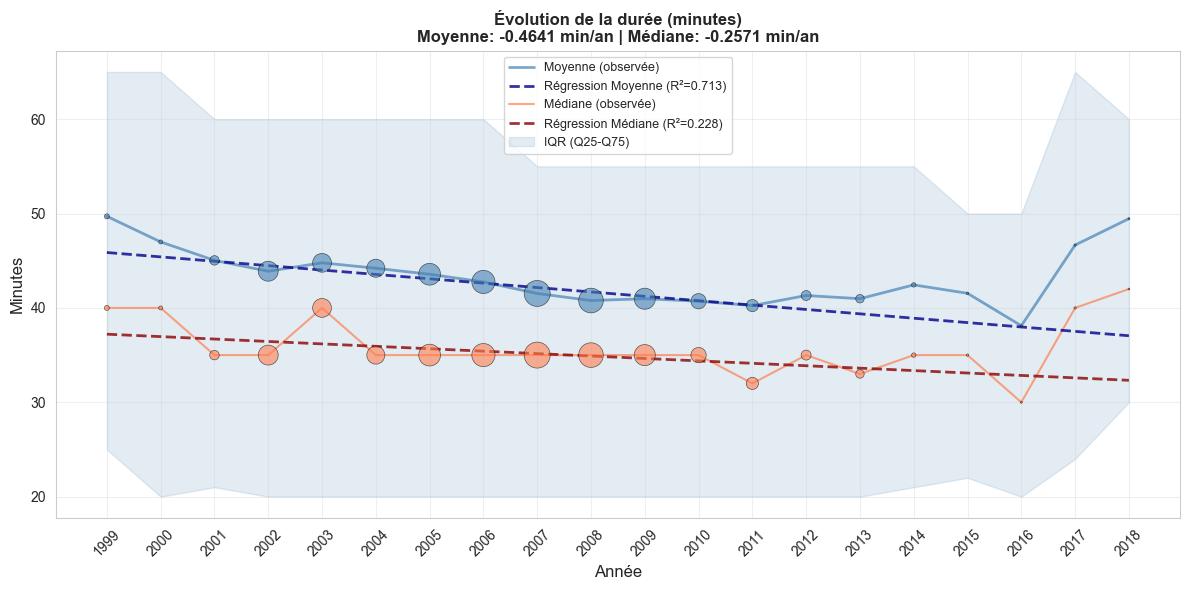

In [5]:
# 📊 Agrégation durée par année (100% POLARS)

minutes_by_year = df.group_by("year").agg([
    pl.mean("minutes").alias("mean_minutes"),
    pl.median("minutes").alias("median_minutes"),
    pl.quantile("minutes", 0.25).alias("q25"),
    pl.quantile("minutes", 0.75).alias("q75"),
    pl.len().alias("n_recipes")
]).sort("year")

# --- CALCUL DES RÉGRESSIONS WLS POUR MEAN ET MEDIAN ---
X = minutes_by_year["year"].to_numpy()
w = minutes_by_year["n_recipes"].to_numpy()

metrics_config = {
    "mean_minutes": {"color": "steelblue", "label": "Moyenne", "ylabel": "minutes/an"},
    "median_minutes": {"color": "coral", "label": "Médiane", "ylabel": "minutes/an"}
}

regressions = {}
for metric_col in metrics_config.keys():
    y = minutes_by_year[metric_col].to_numpy()
    X_const = sm.add_constant(X)
    wls_model = sm.WLS(y, X_const, weights=w)
    wls_result = wls_model.fit()
    y_pred = wls_result.predict(X_const)
    r2_w = 1 - np.average((y - y_pred) ** 2, weights=w) / np.average((y - np.average(y, weights=w)) ** 2, weights=w)
    regressions[metric_col] = {
        "y_pred": y_pred,
        "slope": wls_result.params[1],
        "intercept": wls_result.params[0],
        "r2": r2_w,
        "p_value": wls_result.pvalues[1]
    }

# --- VISUALISATION AVEC RÉGRESSIONS ---
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

sizes = minutes_by_year["n_recipes"].to_numpy() / minutes_by_year["n_recipes"].max() * 350
years = minutes_by_year["year"].to_numpy()
mean_vals = minutes_by_year["mean_minutes"].to_numpy()
median_vals = minutes_by_year["median_minutes"].to_numpy()
q25 = minutes_by_year["q25"].to_numpy()
q75 = minutes_by_year["q75"].to_numpy()

# Moyenne
ax1.plot(years, mean_vals, color="steelblue", linewidth=2, alpha=0.7, label="Moyenne (observée)", zorder=1)
ax1.scatter(years, mean_vals, s=sizes, color="steelblue", alpha=0.6, edgecolors="black", linewidths=0.5, zorder=3)
ax1.plot(years, regressions["mean_minutes"]["y_pred"], color="darkblue", linewidth=2, linestyle="--", alpha=0.8,
         label=f"Régression Moyenne (R²={regressions['mean_minutes']['r2']:.3f})", zorder=2)

# Médiane
ax1.plot(years, median_vals, color="coral", linewidth=1.5, alpha=0.7, label="Médiane (observée)", zorder=1)
ax1.scatter(years, median_vals, s=sizes, color="coral", alpha=0.6, edgecolors="black", linewidths=0.5, zorder=3)
ax1.plot(years, regressions["median_minutes"]["y_pred"], color="darkred", linewidth=2, linestyle="--", alpha=0.8,
         label=f"Régression Médiane (R²={regressions['median_minutes']['r2']:.3f})", zorder=2)

# IQR
ax1.fill_between(years, q25, q75, alpha=0.15, color="steelblue", label="IQR (Q25-Q75)", zorder=0)

# Titres et légendes
title_text = (f"Évolution de la durée (minutes)\n"
              f"Moyenne: {regressions['mean_minutes']['slope']:+.4f} min/an | "
              f"Médiane: {regressions['median_minutes']['slope']:+.4f} min/an")
ax1.set_title(title_text, fontsize=12, fontweight="bold")
ax1.set_xlabel("Année", fontsize=12)
ax1.set_ylabel("Minutes", fontsize=12)
ax1.legend(loc="best", fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(years)
ax1.set_xticklabels([int(y) for y in years], rotation=45)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [6]:
# 📊 ANALYSE : CORRÉLATION ET RÉGRESSION (100% POLARS)
def weighted_spearman(x, y, w):
    """Corrélation de Spearman pondérée par les poids w"""
    rx = rankdata(x)
    ry = rankdata(y)
    mx = np.average(rx, weights=w)
    my = np.average(ry, weights=w)
    cov_xy = np.average((rx - mx) * (ry - my), weights=w)
    sx = np.sqrt(np.average((rx - mx)**2, weights=w))
    sy = np.sqrt(np.average((ry - my)**2, weights=w))
    return cov_xy / (sx * sy)

# Variables pour l'analyse
x = minutes_by_year["year"].to_numpy()
y = minutes_by_year["mean_minutes"].to_numpy()
w = minutes_by_year["n_recipes"].to_numpy()

# --- STATISTIQUES DESCRIPTIVES ---
print("="*80)
print("📊 STATISTIQUES DESCRIPTIVES")
print("="*80)
print(f"\nDurée moyenne (mean_minutes) :")
print(f"   • Moyenne pondérée   : {np.average(y, weights=w):.2f} min")
print(f"   • Min - Max          : {y.min():.2f} → {y.max():.2f} min")
print(f"   • Médiane (années)   : {np.median(y):.2f} min")

# --- CORRÉLATION ---
spearman_corr_w = weighted_spearman(x, y, w)
print(f"\n📈 CORRÉLATION")
print(f"   • Spearman pondérée  : {spearman_corr_w:+.4f}")

# --- RÉGRESSION WLS ---
X = sm.add_constant(x)
wls_model = sm.WLS(y, X, weights=w)
wls_result = wls_model.fit()
y_pred = wls_result.predict(X)

r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)

print(f"\n📉 RÉGRESSION WLS")
print(f"   • Pente              : {wls_result.params[1]:+.4f} min/an")
print(f"   • R² pondéré         : {r2_w:.4f} ({r2_w*100:.1f}%)")
print(f"   • p-value            : {wls_result.pvalues[1]:.6e}")
print(f"   • Significativité    : {'✅ OUI' if wls_result.pvalues[1] < 0.05 else '❌ NON'} (α=0.05)")
print("\n" + "="*80)


📊 STATISTIQUES DESCRIPTIVES

Durée moyenne (mean_minutes) :
   • Moyenne pondérée   : 42.43 min
   • Min - Max          : 38.11 → 49.71 min
   • Médiane (années)   : 42.60 min

📈 CORRÉLATION
   • Spearman pondérée  : -0.8488

📉 RÉGRESSION WLS
   • Pente              : -0.4641 min/an
   • R² pondéré         : 0.7134 (71.3%)
   • p-value            : 2.813729e-06
   • Significativité    : ✅ OUI (α=0.05)



#### Interprétation

> **💡 Interprétation :**  
>  
> **L’analyse de la durée moyenne de préparation** montre une **tendance globale à la baisse** depuis la création du site.  
>  
> En moyenne, le temps de préparation diminue d’environ **−0.46/min par an**, tandis que la médiane recule de **−0.26/min par an**, ce qui traduit une **légère simplification des recettes** au fil du temps.  
> 

### Analyse 3: Évolution de la complexité
#### Visualisation

In [7]:
# Rappel du score de complexité: complexity_score = log1p(minutes) + n_steps + 0.5 * n_ingredients
# où log1p(m)= log(1+m)
# Corrélation entre ingrédients, étapes et minutes.

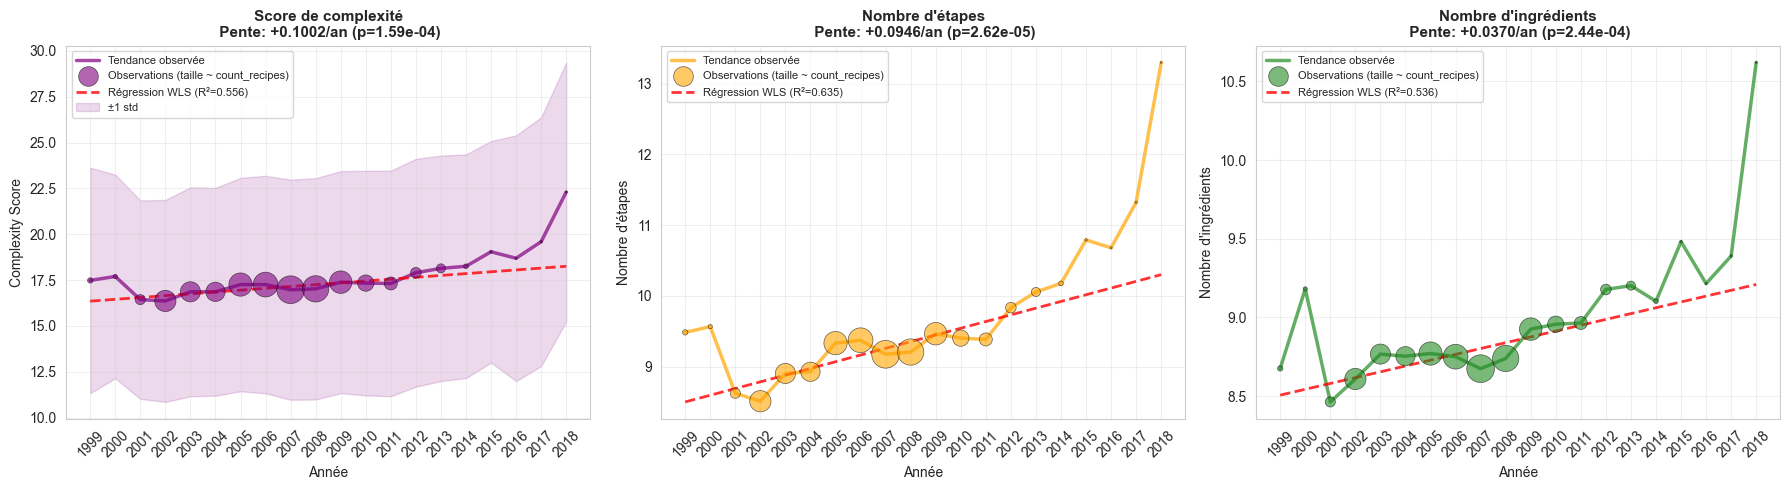

In [8]:
# 📊 Agrégation des données de complexité par année (100% POLARS)

complexity_by_year = df.group_by("year").agg([
    pl.mean("complexity_score").alias("mean_complexity"),
    pl.mean("n_steps").alias("mean_steps"),
    pl.mean("n_ingredients").alias("mean_ingredients"),
    pl.std("complexity_score").alias("std_complexity"),
    pl.count("id").alias("count_recipes")
]).sort("year")

# --- CALCUL DES RÉGRESSIONS WLS POUR LES 3 MÉTRIQUES ---
X = complexity_by_year["year"].to_numpy()
w = complexity_by_year["count_recipes"].to_numpy()

metrics_config = {
    "mean_complexity": {"color": "purple", "marker": "o", "title": "Score de complexité", "ylabel": "Complexity Score", "show_std": True},
    "mean_steps": {"color": "orange", "marker": "s", "title": "Nombre d'étapes", "ylabel": "Nombre d'étapes", "show_std": False},
    "mean_ingredients": {"color": "forestgreen", "marker": "^", "title": "Nombre d'ingrédients", "ylabel": "Nombre d'ingrédients", "show_std": False}
}

regressions = {}
for metric_col in metrics_config.keys():
    y = complexity_by_year[metric_col].to_numpy()
    X_const = sm.add_constant(X)
    wls_model = sm.WLS(y, X_const, weights=w)
    wls_result = wls_model.fit()
    y_pred = wls_result.predict(X_const)
    r2_w = 1 - np.average((y - y_pred) ** 2, weights=w) / np.average((y - np.average(y, weights=w)) ** 2, weights=w)
    regressions[metric_col] = {"y_pred": y_pred, "slope": wls_result.params[1], "r2": r2_w, "p_value": wls_result.pvalues[1]}

# --- VISUALISATION AVEC RÉGRESSIONS ---
sizes = (w / w.max()) * 400
years = complexity_by_year["year"].to_numpy()
mean_complexity = complexity_by_year["mean_complexity"].to_numpy()
std_complexity = complexity_by_year["std_complexity"].to_numpy()
mean_steps = complexity_by_year["mean_steps"].to_numpy()
mean_ingredients = complexity_by_year["mean_ingredients"].to_numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (metric_col, config) in zip(axes, metrics_config.items()):
    reg = regressions[metric_col]
    y_vals = complexity_by_year[metric_col].to_numpy()

    ax.plot(years, y_vals, linewidth=2.5, color=config["color"], alpha=0.7, label="Tendance observée", zorder=1)
    ax.scatter(years, y_vals, s=sizes, alpha=0.6, color=config["color"], edgecolors="black", linewidths=0.5,
               label="Observations (taille ~ count_recipes)", zorder=3)
    ax.plot(years, reg["y_pred"], color="red", linewidth=2, linestyle="--", alpha=0.8,
            label=f"Régression WLS (R²={reg['r2']:.3f})", zorder=2)

    if config.get("show_std"):
        ax.fill_between(years, mean_complexity - std_complexity, mean_complexity + std_complexity,
                        alpha=0.15, color=config["color"], label="±1 std", zorder=0)

    title_text = f"{config['title']}\n Pente: {reg['slope']:+.4f}/an (p={reg['p_value']:.2e})"
    ax.set_title(title_text, fontsize=11, fontweight="bold")
    ax.set_xlabel("Année")
    ax.set_ylabel(config["ylabel"])
    ax.grid(True, alpha=0.3)
    ax.set_xticks(years)
    ax.set_xticklabels([int(y) for y in years], rotation=45)
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


#### Tests statistiques

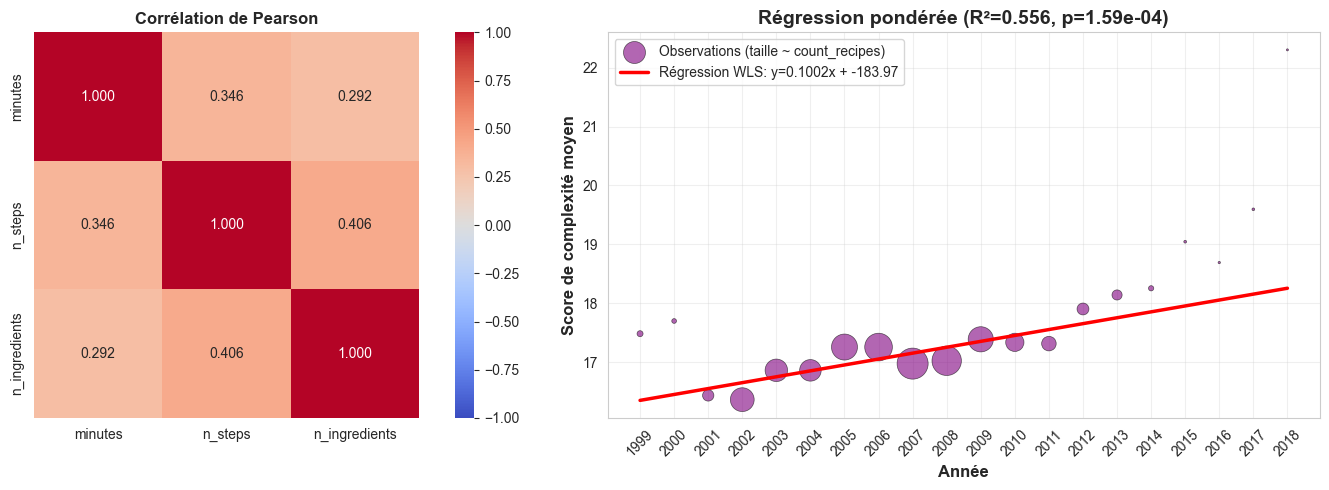

📊 RÉGRESSION LINÉAIRE PONDÉRÉE : complexity_score ~ year
Pente (β₁)            : +0.100208 points/an
Intercept (β₀)        : -183.9656
R² pondéré            : 0.5564 (55.6% variance expliquée)
p-value               : 1.593571e-04
Significativité       : ✅ OUI (α=0.05)


In [9]:
# 📊 Matrice de corrélation complète (minutes, n_steps, n_ingredients) — 100% POLARS

corr_data = df.select(["minutes", "n_steps", "n_ingredients"])
corr_matrix = np.corrcoef(
    [corr_data["minutes"].to_numpy(),
     corr_data["n_steps"].to_numpy(),
     corr_data["n_ingredients"].to_numpy()]
)
pearson_corr = pd.DataFrame(
    corr_matrix, 
    index=["minutes", "n_steps", "n_ingredients"], 
    columns=["minutes", "n_steps", "n_ingredients"]
)

# Variables pour la régression
X = complexity_by_year["year"].to_numpy()
y = complexity_by_year["mean_complexity"].to_numpy()
w = complexity_by_year["count_recipes"].to_numpy()

# Régression WLS (Weighted Least Squares)
X_const = sm.add_constant(X)
wls_model = sm.WLS(y, X_const, weights=w)
wls_result = wls_model.fit()

# Calcul manuel du R² pondéré
y_pred = wls_result.predict(X_const)
r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)

# Corrélation de Spearman (non pondérée)
corr_sp, p_sp = spearmanr(X, y)

# Extraction des paramètres
slope = wls_result.params[1]
intercept = wls_result.params[0]
p_value = wls_result.pvalues[1]

# 📈 VISUALISATION
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# (1) Heatmap de Pearson
sns.heatmap(pearson_corr, annot=True, fmt=".3f", cmap="coolwarm",
            center=0, vmin=-1, vmax=1, square=True, ax=axes[0])
axes[0].set_title("Corrélation de Pearson", fontweight="bold", fontsize=12)

# (2) Régression pondérée
sizes = w / w.max() * 500
axes[1].scatter(X, y, s=sizes, alpha=0.6, color="purple",
                label="Observations (taille ~ count_recipes)",
                edgecolors="black", linewidths=0.5)
axes[1].plot(X, y_pred, color="red", linewidth=2.5,
             label=f"Régression WLS: y={slope:.4f}x + {intercept:.2f}")
axes[1].set_xlabel("Année", fontsize=12, fontweight="bold")
axes[1].set_ylabel("Score de complexité moyen", fontsize=12, fontweight="bold")
axes[1].set_title(f"Régression pondérée (R²={r2_w:.3f}, p={p_value:.2e})",
                  fontsize=14, fontweight="bold")
axes[1].legend(loc="best")
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(X)
axes[1].set_xticklabels([int(x) for x in X], rotation=45)

plt.tight_layout()
plt.show()


# 📊 RÉSULTATS
print("=" * 70)
print("📊 RÉGRESSION LINÉAIRE PONDÉRÉE : complexity_score ~ year")
print("=" * 70)
print(f"Pente (β₁)            : {slope:+.6f} points/an")
print(f"Intercept (β₀)        : {intercept:.4f}")
print(f"R² pondéré            : {r2_w:.4f} ({r2_w*100:.1f}% variance expliquée)")
print(f"p-value               : {p_value:.6e}")
print(f"Significativité       : {'✅ OUI' if p_value < 0.05 else '❌ NON'} (α=0.05)")

#### Interprétation

> **💡 Interprétation statistique :**  
> 
> La **régression linéaire pondérée** (pente = **+0.10**, R² = **0.56**, p = **1.59×10⁻⁴**) met en évidence une **tendance significative à la hausse** du **score moyen de complexité** au fil du temps.  
>
> Cette évolution indique une **augmentation progressive de la complexité des recettes**, d’environ **+0.10 point par an**, suggérant des **préparations de plus en plus élaborées** au cours des années.  
>
> La tendance observée est **cohérente** avec la corrélation positive entre le **nombre d’étapes** et le **nombre d’ingrédients**, confirmant une **complexification globale** des recettes publiées.


### Analyse 4: Évolution nutritionnelle
#### Visualisation

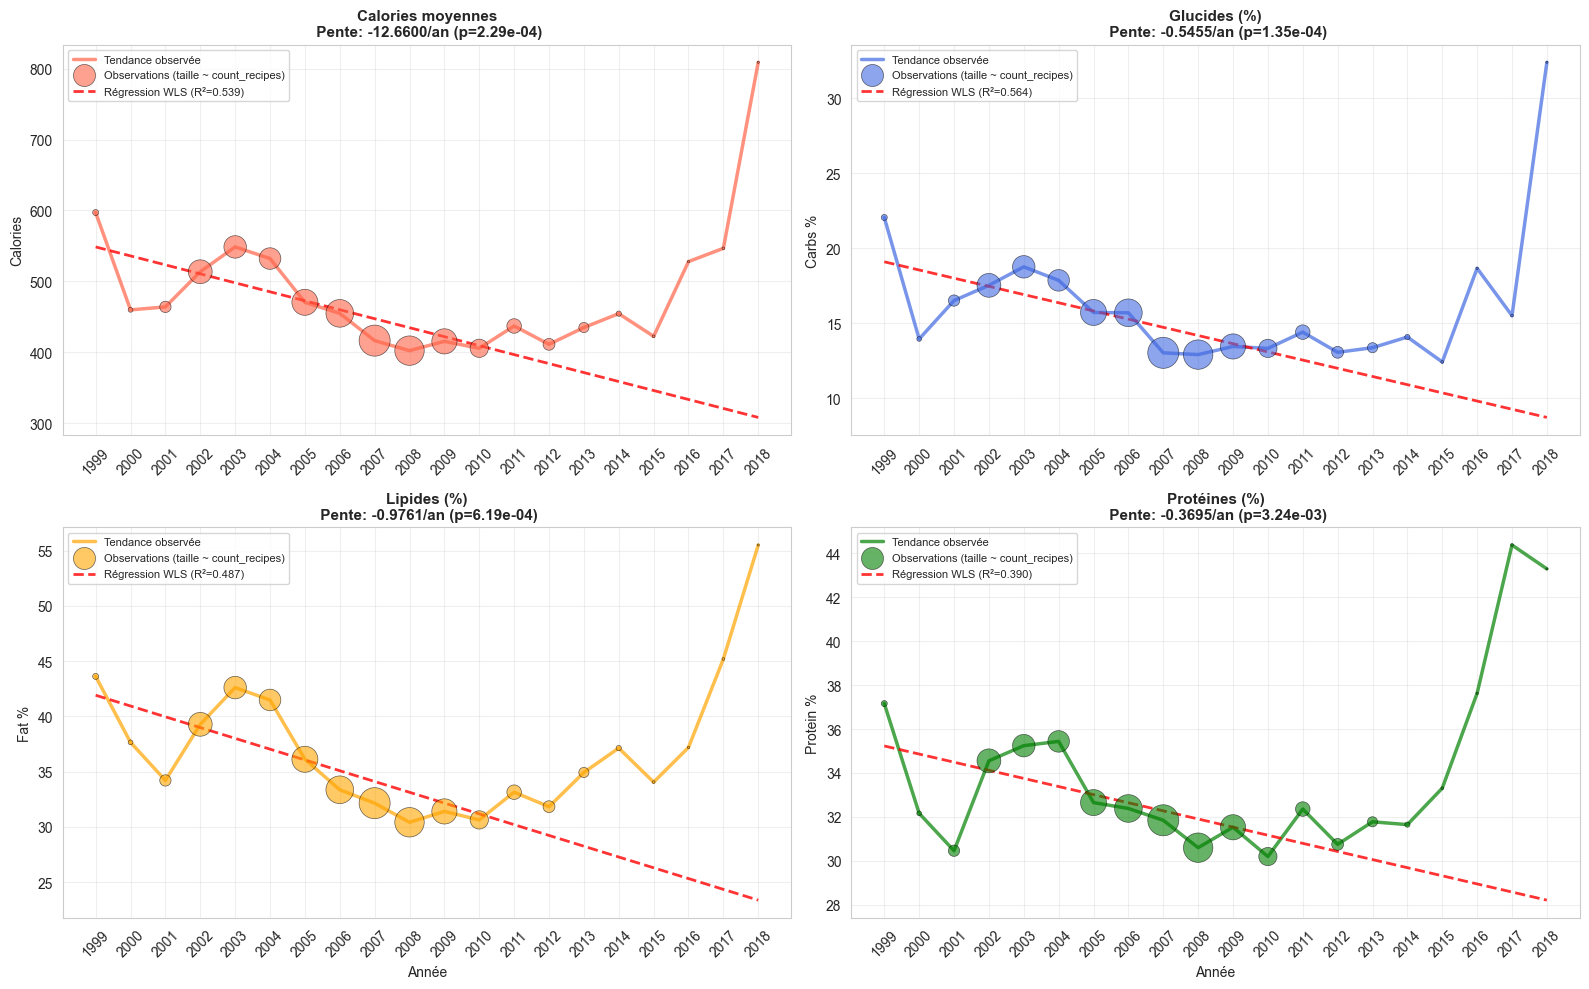

In [10]:
# 📊 Agrégation nutrition par année (Calories, Glucides, Lipides, Protéines) — 100% POLARS

nutrition_by_year = df.group_by("year").agg([
    pl.mean("calories").alias("mean_calories"),
    pl.mean("carb_pct").alias("mean_carbs"),
    pl.mean("total_fat_pct").alias("mean_fat"),
    pl.mean("protein_pct").alias("mean_protein"),
    pl.count("id").alias("count_recipes")
]).sort("year")

# --- CALCUL DES RÉGRESSIONS WLS POUR CHAQUE MÉTRIQUE ---
X_year = nutrition_by_year["year"].to_numpy()
w = nutrition_by_year["count_recipes"].to_numpy()

metrics_config = {
    "mean_calories": {"color": "tomato", "marker": "o", "title": "Calories moyennes", "ylabel": "Calories"},
    "mean_carbs": {"color": "royalblue", "marker": "s", "title": "Glucides (%)", "ylabel": "Carbs %"},
    "mean_fat": {"color": "orange", "marker": "^", "title": "Lipides (%)", "ylabel": "Fat %"},
    "mean_protein": {"color": "green", "marker": "d", "title": "Protéines (%)", "ylabel": "Protein %"}
}

regressions = {}
for metric_col in metrics_config.keys():
    y = nutrition_by_year[metric_col].to_numpy()
    X_const = sm.add_constant(X_year)
    wls_model = sm.WLS(y, X_const, weights=w)
    wls_result = wls_model.fit()
    y_pred = wls_result.predict(X_const)
    r2_w = 1 - np.average((y - y_pred)**2, weights=w) / np.average((y - np.average(y, weights=w))**2, weights=w)
    regressions[metric_col] = {
        "y_pred": y_pred,
        "slope": wls_result.params[1],
        "intercept": wls_result.params[0],
        "r2": r2_w,
        "p_value": wls_result.pvalues[1]
    }

# --- CALCUL DES TAILLES DE BULLES ---
sizes = (w / w.max()) * 500

# --- VISUALISATION AVEC COURBES + BULLES + RÉGRESSIONS ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes_flat = [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]
years = nutrition_by_year["year"].to_numpy()

for ax, (metric_col, config) in zip(axes_flat, metrics_config.items()):
    reg = regressions[metric_col]
    y_vals = nutrition_by_year[metric_col].to_numpy()

    ax.plot(years, y_vals, linewidth=2.5, color=config["color"], alpha=0.7,
            label="Tendance observée", zorder=1)
    ax.scatter(years, y_vals, s=sizes, alpha=0.6, color=config["color"],
               edgecolors="black", linewidths=0.5,
               label="Observations (taille ~ count_recipes)", zorder=3)
    ax.plot(years, reg["y_pred"], color="red", linewidth=2, linestyle="--", alpha=0.8,
            label=f"Régression WLS (R²={reg['r2']:.3f})", zorder=2)

    title_text = f"{config['title']}\n Pente: {reg['slope']:+.4f}/an (p={reg['p_value']:.2e})"
    ax.set_title(title_text, fontsize=11, fontweight="bold")
    ax.set_ylabel(config["ylabel"])
    if ax in [axes[1,0], axes[1,1]]:
        ax.set_xlabel("Année")

    ax.grid(True, alpha=0.3)
    ax.set_xticks(years)
    ax.set_xticklabels([int(y) for y in years], rotation=45)
    ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [11]:
print("=" * 80)
print("📊 RÉSUMÉ DES RÉGRESSIONS LINÉAIRES PONDÉRÉES (WLS) - NUTRITION")
print("=" * 80)

for metric_col, config in metrics_config.items():
    reg = regressions[metric_col]
    sig_icon = "✅" if reg["p_value"] < 0.05 else "❌"
    print(f"\n📈 {config['title'].upper()}")
    print(f"   • Pente (β₁)         : {reg['slope']:+.6f} {config['ylabel']}/an")
    print(f"   • Intercept (β₀)     : {reg['intercept']:.4f}")
    print(f"   • R² pondéré         : {reg['r2']:.4f} ({reg['r2']*100:.1f}% variance expliquée)")
    print(f"   • p-value            : {reg['p_value']:.6e}")
    print(f"   • Significativité    : {sig_icon} {'OUI' if reg['p_value'] < 0.05 else 'NON'} (α=0.05)")
    print("-" * 80)

📊 RÉSUMÉ DES RÉGRESSIONS LINÉAIRES PONDÉRÉES (WLS) - NUTRITION

📈 CALORIES MOYENNES
   • Pente (β₁)         : -12.659994 Calories/an
   • Intercept (β₀)     : 25855.7884
   • R² pondéré         : 0.5388 (53.9% variance expliquée)
   • p-value            : 2.293671e-04
   • Significativité    : ✅ OUI (α=0.05)
--------------------------------------------------------------------------------

📈 GLUCIDES (%)
   • Pente (β₁)         : -0.545453 Carbs %/an
   • Intercept (β₀)     : 1109.4619
   • R² pondéré         : 0.5643 (56.4% variance expliquée)
   • p-value            : 1.347520e-04
   • Significativité    : ✅ OUI (α=0.05)
--------------------------------------------------------------------------------

📈 LIPIDES (%)
   • Pente (β₁)         : -0.976081 Fat %/an
   • Intercept (β₀)     : 1993.0989
   • R² pondéré         : 0.4874 (48.7% variance expliquée)
   • p-value            : 6.188384e-04
   • Significativité    : ✅ OUI (α=0.05)
-----------------------------------------------------

#### Interprétation

> **💡 Interprétation :**  
>
> Les **régressions linéaires pondérées** montrent une **tendance significative à la baisse** des valeurs **nutritionnelles moyennes** au fil du temps.  
>
> Les **calories**, **glucides**, **lipides** et **protéines** présentent toutes des **pentes négatives**, avec des **R² pondérés entre 0.39 et 0.56**, indiquant une **bonne part de variance expliquée** et une **diminution mesurable** des apports nutritionnels moyens par recette.  
>
> Cette évolution traduit une **orientation progressive vers des recettes plus légères**, moins riches en **calories** et en **macronutriments**, reflétant probablement une **adaptation aux tendances alimentaires modernes** (recherche de plats plus équilibrés et moins énergétiques).  

### Analyse 5: Évolution des ingrédients
#### Visualisation

🔄 Normalisation des ingrédients en cours...
✅ 1,762,665 ingrédients individuels extraits


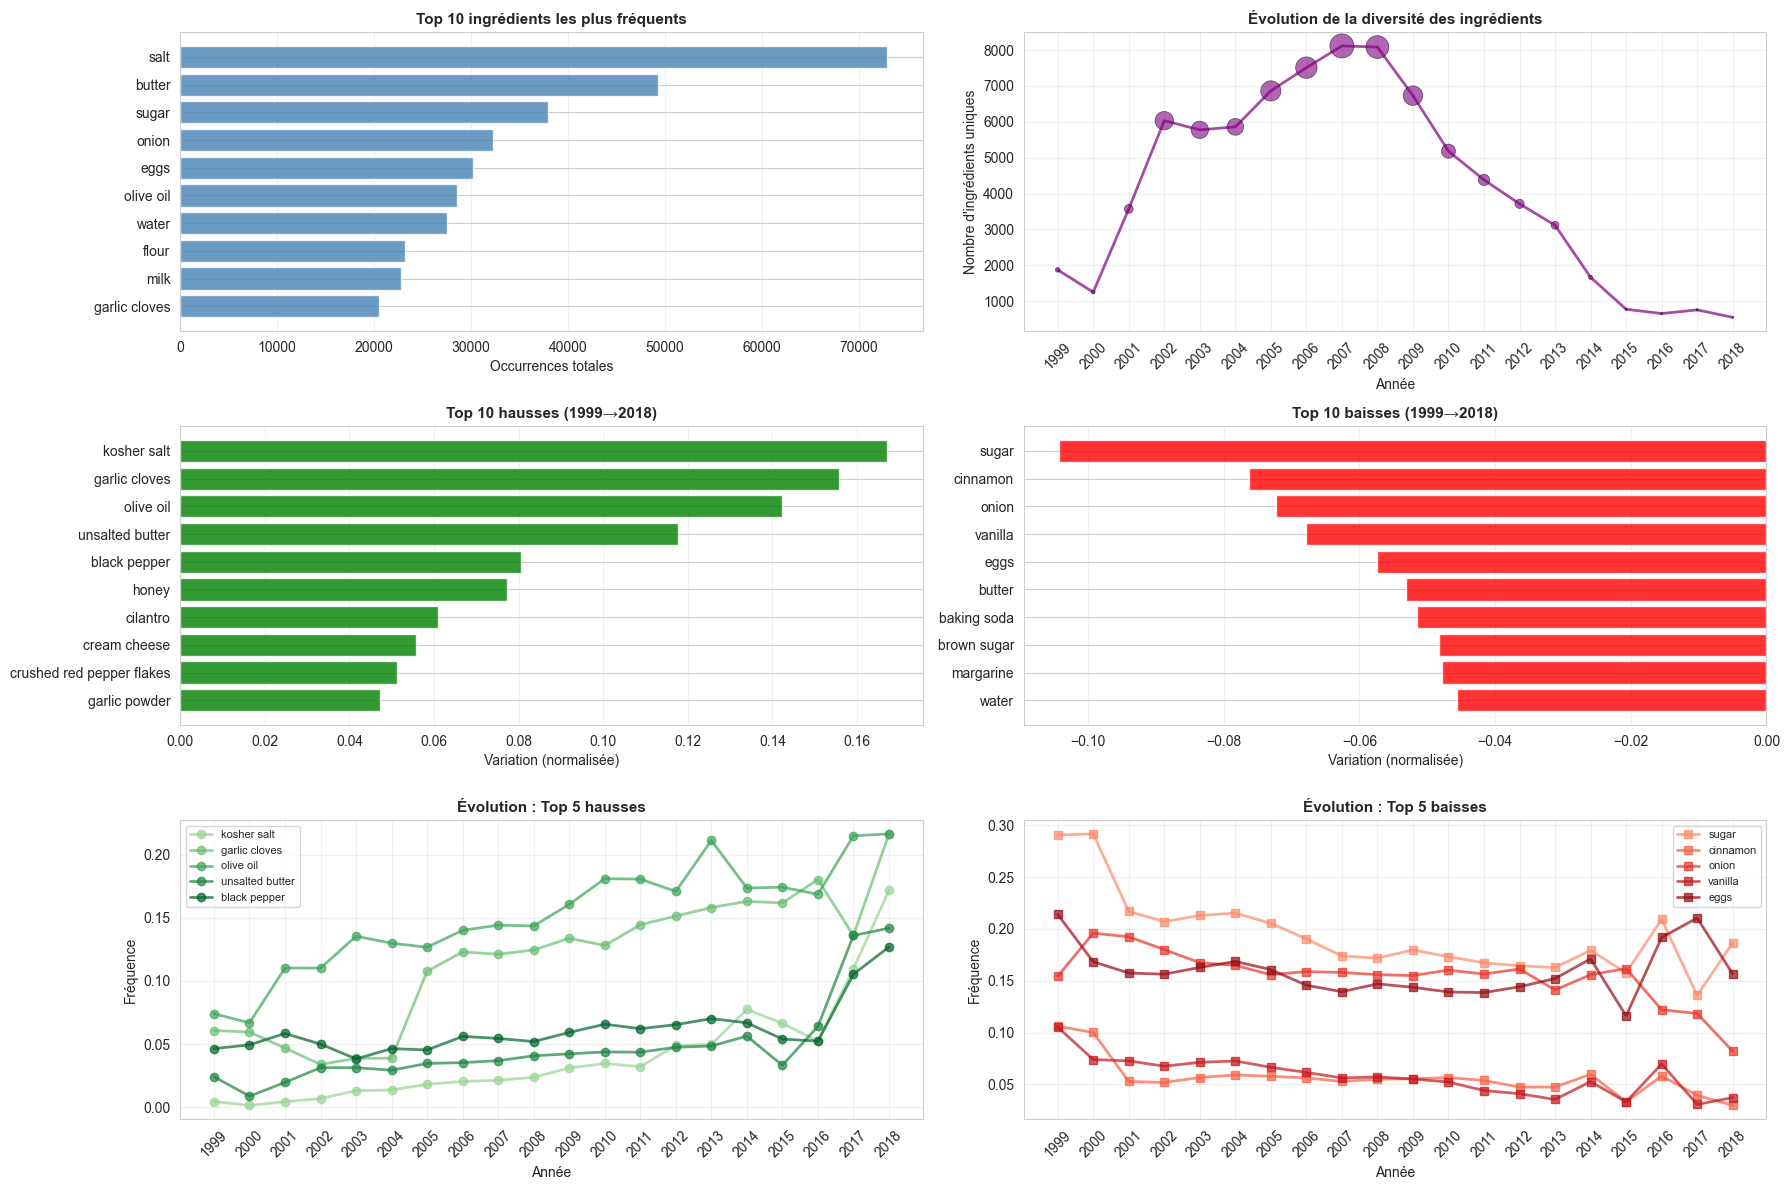


✅ Visualisation terminée !
 • 2,415 ingrédients analysés (≥ 50 occurrences)
 • Diversité : 1,872 (1999) → 548 (2018)


In [12]:
# --- PARAMÈTRES ---
NORMALIZE = True  # Normaliser par le nb de recettes de l'année
MIN_TOTAL_OCC = 50  # Seuil min d'occurrences globales
TOP_N = 10  # Top hausses/baisses à afficher
N_VARIATIONS = 5  # Nombre d'ingrédients à tracer

# --- 0. PRÉPARATION : NORMALISATION DES INGRÉDIENTS ---
print("🔄 Normalisation des ingrédients en cours...")

df_ingredients = (
    df.select(['id', 'year', 'ingredients'])
    .explode('ingredients')
    .with_columns([
        pl.col('ingredients').str.to_lowercase().str.strip_chars().alias('ingredient_norm')
    ])
)

print(f"✅ {df_ingredients.shape[0]:,} ingrédients individuels extraits")

# --- 1. FRÉQUENCE GLOBALE DES INGRÉDIENTS ---
freq_global = (
    df_ingredients
    .group_by('ingredient_norm')
    .agg(pl.count('id').alias('total_count'))
    .filter(pl.col('total_count') >= MIN_TOTAL_OCC)
    .sort('total_count', descending=True)
)

top_global = freq_global.head(TOP_N)

# --- 2. FRÉQUENCE PAR ANNÉE ---
freq_year_ing = (
    df_ingredients
    .group_by(['year', 'ingredient_norm'])
    .agg(pl.count('ingredient_norm').alias('count'))
)

# Nombre de recettes par année
year_totals = df.group_by('year').agg(pl.count('id').alias('n_recipes'))

# Joindre et normaliser
freq_year_ing = freq_year_ing.join(year_totals, on='year', how='left')

if NORMALIZE:
    freq_year_ing = freq_year_ing.with_columns(
        (pl.col('count') / pl.col('n_recipes')).alias('freq')
    )
else:
    freq_year_ing = freq_year_ing.with_columns(pl.col('count').alias('freq'))

# --- 3. CALCUL DES VARIATIONS ---
min_year = df['year'].min()
max_year = df['year'].max()

first_year_vals = (
    freq_year_ing
    .filter(pl.col('year') == min_year)
    .select(['ingredient_norm', pl.col('freq').alias('first')])
)

last_year_vals = (
    freq_year_ing
    .filter(pl.col('year') == max_year)
    .select(['ingredient_norm', pl.col('freq').alias('last')])
)

variation = (
    first_year_vals
    .join(last_year_vals, on='ingredient_norm', how='full')
    .with_columns([
        pl.col('first').fill_null(0),
        pl.col('last').fill_null(0)
    ])
    .with_columns(
        (pl.col('last') - pl.col('first')).alias('delta')
    )
)

# Filtrer pour avoir suffisamment d'occurrences
variation = (
    variation
    .join(freq_global.select(['ingredient_norm', 'total_count']), on='ingredient_norm', how='left')
    .filter(pl.col('total_count') >= MIN_TOTAL_OCC)
)

biggest_increase = variation.sort('delta', descending=True).head(TOP_N)
biggest_decrease = variation.sort('delta', descending=False).head(TOP_N)

# --- 4. DIVERSITÉ (NOMBRE D'INGRÉDIENTS UNIQUES) ---
unique_per_year = (
    df_ingredients
    .group_by('year')
    .agg(pl.n_unique('ingredient_norm').alias('n_unique'))
    .sort('year')
)

# --- VISUALISATION ---
fig = plt.figure(figsize=(18, 12))

# (1) Top 10 ingrédients (barres horizontales)
ax1 = plt.subplot(3, 2, 1)
top_global_data = top_global.to_pandas()
ax1.barh(range(len(top_global_data)), top_global_data['total_count'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_global_data)))
ax1.set_yticklabels(top_global_data['ingredient_norm'])
ax1.invert_yaxis()
ax1.set_xlabel('Occurrences totales')
ax1.set_title(f'Top {TOP_N} ingrédients les plus fréquents', fontweight='bold', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# (2) Évolution de la diversité
ax2 = plt.subplot(3, 2, 2)
unique_data = unique_per_year.to_pandas()
year_totals_data = year_totals.sort('year').to_pandas()
w_div = year_totals_data['n_recipes'].values
sizes_div = (w_div / w_div.max()) * 300
ax2.plot(unique_data['year'], unique_data['n_unique'], color='purple', linewidth=2, alpha=0.7, label='Diversité observée', zorder=1)
ax2.scatter(unique_data['year'], unique_data['n_unique'], s=sizes_div, color='purple', alpha=0.6, edgecolors='black', linewidths=0.5, zorder=3)
ax2.set_xlabel('Année')
ax2.set_ylabel('Nombre d\'ingrédients uniques')
ax2.set_title('Évolution de la diversité des ingrédients', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(unique_data['year'])
ax2.set_xticklabels([int(y) for y in unique_data['year']], rotation=45)

# (3) Top hausses (barres horizontales)
ax3 = plt.subplot(3, 2, 3)
label_delta = 'Variation (normalisée)' if NORMALIZE else 'Variation (occurrences)'
increase_data = biggest_increase.to_pandas()
ax3.barh(range(len(increase_data)), increase_data['delta'], color='green', alpha=0.8)
ax3.set_yticks(range(len(increase_data)))
ax3.set_yticklabels(increase_data['ingredient_norm'])
ax3.invert_yaxis()
ax3.set_xlabel(label_delta)
ax3.set_title(f'Top {TOP_N} hausses ({min_year}→{max_year})', fontweight='bold', fontsize=11)
ax3.grid(axis='x', alpha=0.3)

# (4) Top baisses (barres horizontales)
ax4 = plt.subplot(3, 2, 4)
decrease_data = biggest_decrease.to_pandas()
ax4.barh(range(len(decrease_data)), decrease_data['delta'], color='red', alpha=0.8)
ax4.set_yticks(range(len(decrease_data)))
ax4.set_yticklabels(decrease_data['ingredient_norm'])
ax4.invert_yaxis()
ax4.set_xlabel(label_delta)
ax4.set_title(f'Top {TOP_N} baisses ({min_year}→{max_year})', fontweight='bold', fontsize=11)
ax4.grid(axis='x', alpha=0.3)

# (5) Évolution de quelques ingrédients en hausse
ax_inc = plt.subplot(3, 2, 5)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, N_VARIATIONS))
freq_year_data = freq_year_ing.to_pandas()
for idx, row in enumerate(biggest_increase.head(N_VARIATIONS).iter_rows(named=True)):
    ing = row['ingredient_norm']
    data_ing = freq_year_data[freq_year_data['ingredient_norm'] == ing].sort_values('year')
    ax_inc.plot(data_ing['year'], data_ing['freq'], marker='o', linewidth=2, alpha=0.7, color=colors[idx], label=ing)
ax_inc.set_xlabel('Année')
ax_inc.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_inc.set_title(f'Évolution : Top {N_VARIATIONS} hausses', fontweight='bold', fontsize=11)
ax_inc.legend(loc='best', fontsize=8)
ax_inc.grid(True, alpha=0.3)
ax_inc.set_xticks(unique_data['year'])
ax_inc.set_xticklabels([int(y) for y in unique_data['year']], rotation=45)

# (6) Évolution de quelques ingrédients en baisse
ax_dec = plt.subplot(3, 2, 6)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, N_VARIATIONS))
for idx, row in enumerate(biggest_decrease.head(N_VARIATIONS).iter_rows(named=True)):
    ing = row['ingredient_norm']
    data_ing = freq_year_data[freq_year_data['ingredient_norm'] == ing].sort_values('year')
    ax_dec.plot(data_ing['year'], data_ing['freq'], marker='s', linewidth=2, alpha=0.7, color=colors[idx], label=ing)
ax_dec.set_xlabel('Année')
ax_dec.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_dec.set_title(f'Évolution : Top {N_VARIATIONS} baisses', fontweight='bold', fontsize=11)
ax_dec.legend(loc='best', fontsize=8)
ax_dec.grid(True, alpha=0.3)
ax_dec.set_xticks(unique_data['year'])
ax_dec.set_xticklabels([int(y) for y in unique_data['year']], rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualisation terminée !")
print(f" • {len(freq_global):,} ingrédients analysés (≥ {MIN_TOTAL_OCC} occurrences)")
print(f" • Diversité : {unique_per_year[0, 'n_unique']:,} ({min_year}) → {unique_per_year[-1, 'n_unique']:,} ({max_year})")

#### Tests statistiques

In [13]:
print("="*80)
print("📊 STATISTIQUES - ÉVOLUTION DES INGRÉDIENTS")
print("="*80)

# --- 1. STATISTIQUES GLOBALES ---
print(f"\n1️⃣ STATISTIQUES GLOBALES")
print(f" • Période : {min_year} → {max_year}")
print(f" • Total ingrédients : {len(freq_global):,}")
print(f" • Seuil occurrences : ≥ {MIN_TOTAL_OCC}")

# --- 2. TOP 10 INGRÉDIENTS ---
print(f"\n2️⃣ TOP 10 INGRÉDIENTS (occurrences totales)")
print("-" * 80)
for row in top_global.head(10).iter_rows(named=True):
    print(f" {row['ingredient_norm']:30s} : {row['total_count']:>8,} occurrences")

# --- 3. PLUS FORTES HAUSSES ---
print(f"\n3️⃣ TOP 10 HAUSSES ({min_year}→{max_year})")
print("-" * 80)
for row in biggest_increase.head(10).iter_rows(named=True):
    # Format adapté selon normalisation ou valeurs brutes
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f" {row['ingredient_norm']:30s} : {delta_txt:>12s}")

# --- 4. PLUS FORTES BAISSES ---
print(f"\n4️⃣ TOP 10 BAISSES ({min_year}→{max_year})")
print("-" * 80)
for row in biggest_decrease.head(10).iter_rows(named=True):
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f" {row['ingredient_norm']:30s} : {delta_txt:>12s}")

# --- 5. DIVERSITÉ ---
print(f"\n5️⃣ ÉVOLUTION DE LA DIVERSITÉ")
print("-" * 80)
first_unique = unique_per_year[0, 'n_unique']
last_unique = unique_per_year[-1, 'n_unique']
delta_unique = last_unique - first_unique
pct_change = (delta_unique / first_unique) * 100
print(f" • {min_year} : {first_unique:,} ingrédients uniques")
print(f" • {max_year} : {last_unique:,} ingrédients uniques")
print(f" • Évolution : {delta_unique:+,} ({pct_change:+.1f}%)")

# --- 6. RÉGRESSION SUR LA DIVERSITÉ ---
X_div = unique_per_year['year'].to_numpy()
y_div = unique_per_year['n_unique'].to_numpy()
w_div = year_totals.sort('year')['n_recipes'].to_numpy()

# Régression linéaire pondérée
X_const = sm.add_constant(X_div)
model = sm.WLS(y_div, X_const, weights=w_div).fit()

# R² pondéré
y_pred = model.predict(X_const)
ss_res = np.average((y_div - y_pred)**2, weights=w_div)
ss_tot = np.average((y_div - np.mean(y_div))**2, weights=w_div)
r2_w = 1 - (ss_res / ss_tot)

print(f"\n6️⃣ RÉGRESSION LINÉAIRE (diversité ~ année)")
print("-" * 80)
print(f" • Pente : {model.params[1]:+.2f} ingrédients/an")
print(f" • R² : {r2_w:.3f}")
print(f" • p-value : {model.pvalues[1]:.4f}")
print(f" • Significatif ? : {'Oui' if model.pvalues[1] < 0.05 else 'Non'} (α=0.05)")

print("\n" + "="*80)

📊 STATISTIQUES - ÉVOLUTION DES INGRÉDIENTS

1️⃣ STATISTIQUES GLOBALES
 • Période : 1999 → 2018
 • Total ingrédients : 2,415
 • Seuil occurrences : ≥ 50

2️⃣ TOP 10 INGRÉDIENTS (occurrences totales)
--------------------------------------------------------------------------------
 salt                           :   72,911 occurrences
 butter                         :   49,288 occurrences
 sugar                          :   37,949 occurrences
 onion                          :   32,219 occurrences
 eggs                           :   30,142 occurrences
 olive oil                      :   28,487 occurrences
 water                          :   27,542 occurrences
 flour                          :   23,202 occurrences
 milk                           :   22,729 occurrences
 garlic cloves                  :   20,467 occurrences

3️⃣ TOP 10 HAUSSES (1999→2018)
--------------------------------------------------------------------------------
 kosher salt                    :      +0.1672
 garlic clo

#### Interprétation

> **💡 Interprétation :**
>
> L'analyse révèle une **transformation profonde** de l'usage des ingrédients au fil du temps.
>
> **Tendances montantes** : Des ingrédients comme *kosher salt*, *garlic cloves*, *olive oil* et *unsalted butter* connaissent une forte progression, reflétant peut-être un virage vers une cuisine plus communautaire ou méditerranéenne.
>
> **Tendances descendantes** : Les ingrédients traditionnels comme *sugar*, *butter*, *eggs* et *vanilla* sont en net recul, suggérant une diminution des recettes de pâtisserie classique et une recherche de recettes moins sucrées.
>
> **Chute de la diversité** : Le nombre d'ingrédients uniques chute drastiquement, passant du maximum en début de période à un minimum en fin de période. Cette baisse significative s'explique par la diminution du volume de recettes postées après 2007, entraînant une concentration sur des ingrédients plus courants et une perte d'innovation culinaire.

### Analyse 6: Évolution des tags
#### Visualisation

🔄 Normalisation des tags en cours...
✅ 3,583,281 tags individuels extraits


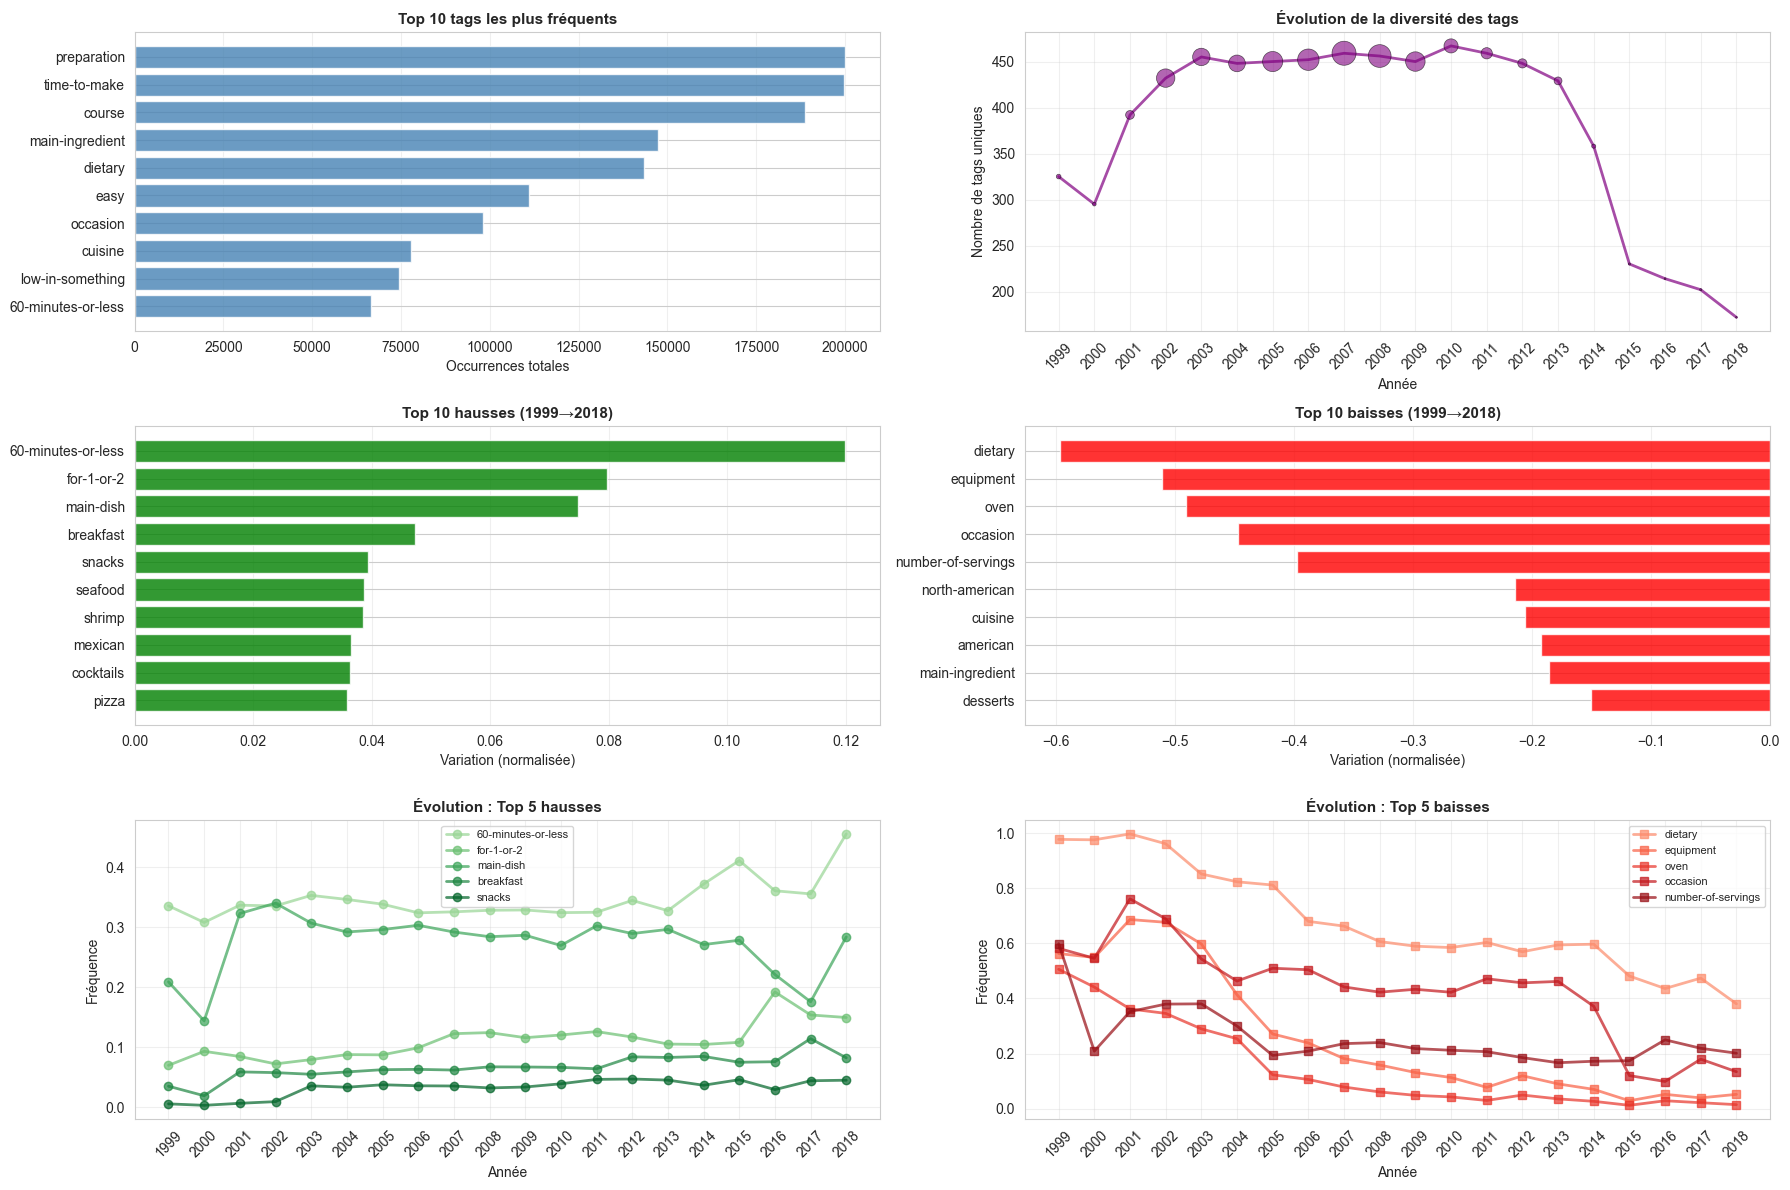


✅ Visualisation terminée !
   • 429 tags analysés (≥ 50 occurrences)
   • Diversité : 325 (1999) → 172 (2018)


In [14]:
# 📊 ANALYSE DES TAGS PAR ANNÉE (MODE POLARS PUR)

# --- PARAMÈTRES ---
NORMALIZE = True  # Normaliser par le nb de recettes de l'année
MIN_TOTAL_OCC = 50  # Seuil min d'occurrences globales
TOP_N = 10  # Top hausses/baisses à afficher
N_VARIATIONS = 5  # Nombre de tags à tracer

# --- 0. PRÉPARATION : NORMALISATION DES TAGS ---
print("🔄 Normalisation des tags en cours...")

# Exploser la liste de tags et normaliser (lowercase + strip)
df_tags = (
    df.select(['id', 'year', 'tags'])
    .explode('tags')
    .with_columns([
        pl.col('tags').str.to_lowercase().str.strip_chars().alias('tag_norm')
    ])
)

print(f"✅ {df_tags.shape[0]:,} tags individuels extraits")

# --- 1. FRÉQUENCE GLOBALE DES TAGS ---
freq_global_tags = (
    df_tags
    .group_by('tag_norm')
    .agg(pl.count('id').alias('total_count'))
    .filter(pl.col('total_count') >= MIN_TOTAL_OCC)
    .sort('total_count', descending=True)
)

top_global_tags = freq_global_tags.head(TOP_N)

# --- 2. FRÉQUENCE PAR ANNÉE ---
freq_year_tag = (
    df_tags
    .group_by(['year', 'tag_norm'])
    .agg(pl.count('tag_norm').alias('count'))
)

# Nombre de recettes par année
year_totals_tags = df.group_by('year').agg(pl.count('id').alias('n_recipes'))

# Joindre et normaliser
freq_year_tag = freq_year_tag.join(year_totals_tags, on='year', how='left')

if NORMALIZE:
    freq_year_tag = freq_year_tag.with_columns(
        (pl.col('count') / pl.col('n_recipes')).alias('freq')
    )
else:
    freq_year_tag = freq_year_tag.with_columns(pl.col('count').alias('freq'))

# --- 3. CALCUL DES VARIATIONS ---
min_year_tags = df['year'].min()
max_year_tags = df['year'].max()

first_year_vals_tags = (
    freq_year_tag
    .filter(pl.col('year') == min_year_tags)
    .select(['tag_norm', pl.col('freq').alias('first')])
)

last_year_vals_tags = (
    freq_year_tag
    .filter(pl.col('year') == max_year_tags)
    .select(['tag_norm', pl.col('freq').alias('last')])
)

variation_tags = (
    first_year_vals_tags
    .join(last_year_vals_tags, on='tag_norm', how='full')
    .with_columns([
        pl.col('first').fill_null(0),
        pl.col('last').fill_null(0)
    ])
    .with_columns(
        (pl.col('last') - pl.col('first')).alias('delta')
    )
)

# Filtrer pour avoir suffisamment d'occurrences
variation_tags = (
    variation_tags
    .join(freq_global_tags.select(['tag_norm', 'total_count']), on='tag_norm', how='left')
    .filter(pl.col('total_count') >= MIN_TOTAL_OCC)
)

biggest_increase_tags = variation_tags.sort('delta', descending=True).head(TOP_N)
biggest_decrease_tags = variation_tags.sort('delta', descending=False).head(TOP_N)

# --- 4. DIVERSITÉ (NOMBRE DE TAGS UNIQUES) ---
unique_per_year_tags = (
    df_tags
    .group_by('year')
    .agg(pl.n_unique('tag_norm').alias('n_unique'))
    .sort('year')
)

# --- VISUALISATION ---
fig = plt.figure(figsize=(18, 12))

# (1) Top 10 tags (barres horizontales)
ax1 = plt.subplot(3, 2, 1)
top_global_tags_data = top_global_tags.to_pandas()
ax1.barh(range(len(top_global_tags_data)), top_global_tags_data['total_count'], color='steelblue', alpha=0.8)
ax1.set_yticks(range(len(top_global_tags_data)))
ax1.set_yticklabels(top_global_tags_data['tag_norm'])
ax1.invert_yaxis()
ax1.set_xlabel('Occurrences totales')
ax1.set_title(f'Top {TOP_N} tags les plus fréquents', fontweight='bold', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# (2) Évolution de la diversité
ax2 = plt.subplot(3, 2, 2)
unique_data_tags = unique_per_year_tags.to_pandas()
year_totals_tags_data = year_totals_tags.sort('year').to_pandas()
w_div_tags = year_totals_tags_data['n_recipes'].values
sizes_div_tags = (w_div_tags / w_div_tags.max()) * 300
ax2.plot(unique_data_tags['year'], unique_data_tags['n_unique'], 
         color='purple', linewidth=2, alpha=0.7, label='Diversité observée', zorder=1)
ax2.scatter(unique_data_tags['year'], unique_data_tags['n_unique'],
            s=sizes_div_tags, color='purple', alpha=0.6, 
            edgecolors='black', linewidths=0.5, zorder=3)
ax2.set_xlabel('Année')
ax2.set_ylabel('Nombre de tags uniques')
ax2.set_title('Évolution de la diversité des tags', fontweight='bold', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(unique_data_tags['year'])
ax2.set_xticklabels([int(y) for y in unique_data_tags['year']], rotation=45)

# (3) Top hausses (barres horizontales)
ax3 = plt.subplot(3, 2, 3)
label_delta_tags = 'Variation (normalisée)' if NORMALIZE else 'Variation (occurrences)'
increase_data_tags = biggest_increase_tags.to_pandas()
ax3.barh(range(len(increase_data_tags)), increase_data_tags['delta'], color='green', alpha=0.8)
ax3.set_yticks(range(len(increase_data_tags)))
ax3.set_yticklabels(increase_data_tags['tag_norm'])
ax3.invert_yaxis()
ax3.set_xlabel(label_delta_tags)
ax3.set_title(f'Top {TOP_N} hausses ({min_year_tags}→{max_year_tags})', fontweight='bold', fontsize=11)
ax3.grid(axis='x', alpha=0.3)

# (4) Top baisses (barres horizontales)
ax4 = plt.subplot(3, 2, 4)
decrease_data_tags = biggest_decrease_tags.to_pandas()
ax4.barh(range(len(decrease_data_tags)), decrease_data_tags['delta'], color='red', alpha=0.8)
ax4.set_yticks(range(len(decrease_data_tags)))
ax4.set_yticklabels(decrease_data_tags['tag_norm'])
ax4.invert_yaxis()
ax4.set_xlabel(label_delta_tags)
ax4.set_title(f'Top {TOP_N} baisses ({min_year_tags}→{max_year_tags})', fontweight='bold', fontsize=11)
ax4.grid(axis='x', alpha=0.3)

# (5) Évolution de quelques tags en hausse
ax_inc = plt.subplot(3, 2, 5)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, N_VARIATIONS))
freq_year_tag_data = freq_year_tag.to_pandas()
for idx, row in enumerate(biggest_increase_tags.head(N_VARIATIONS).iter_rows(named=True)):
    tag = row['tag_norm']
    data_tag = freq_year_tag_data[freq_year_tag_data['tag_norm'] == tag].sort_values('year')
    ax_inc.plot(data_tag['year'], data_tag['freq'], 
                marker='o', linewidth=2, alpha=0.7, color=colors[idx],
                label=tag)
ax_inc.set_xlabel('Année')
ax_inc.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_inc.set_title(f'Évolution : Top {N_VARIATIONS} hausses', fontweight='bold', fontsize=11)
ax_inc.legend(loc='best', fontsize=8)
ax_inc.grid(True, alpha=0.3)
ax_inc.set_xticks(unique_data_tags['year'])
ax_inc.set_xticklabels([int(y) for y in unique_data_tags['year']], rotation=45)

# (6) Évolution de quelques tags en baisse
ax_dec = plt.subplot(3, 2, 6)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, N_VARIATIONS))
for idx, row in enumerate(biggest_decrease_tags.head(N_VARIATIONS).iter_rows(named=True)):
    tag = row['tag_norm']
    data_tag = freq_year_tag_data[freq_year_tag_data['tag_norm'] == tag].sort_values('year')
    ax_dec.plot(data_tag['year'], data_tag['freq'], 
                marker='s', linewidth=2, alpha=0.7, color=colors[idx],
                label=tag)
ax_dec.set_xlabel('Année')
ax_dec.set_ylabel('Fréquence' if NORMALIZE else 'Occurrences')
ax_dec.set_title(f'Évolution : Top {N_VARIATIONS} baisses', fontweight='bold', fontsize=11)
ax_dec.legend(loc='best', fontsize=8)
ax_dec.grid(True, alpha=0.3)
ax_dec.set_xticks(unique_data_tags['year'])
ax_dec.set_xticklabels([int(y) for y in unique_data_tags['year']], rotation=45)

plt.tight_layout()
plt.show()

print(f"\n✅ Visualisation terminée !")
print(f"   • {len(freq_global_tags):,} tags analysés (≥ {MIN_TOTAL_OCC} occurrences)")
print(f"   • Diversité : {unique_per_year_tags[0, 'n_unique']:,} ({min_year_tags}) → {unique_per_year_tags[-1, 'n_unique']:,} ({max_year_tags})")

#### Tests statistiques

In [15]:
# 📊 TESTS STATISTIQUES - ÉVOLUTION DES TAGS (MODE POLARS PUR)
print("="*80)
print("📊 STATISTIQUES - ÉVOLUTION DES TAGS")
print("="*80)

# --- 1. STATISTIQUES GLOBALES ---
print(f"\n1️⃣ STATISTIQUES GLOBALES")
print(f" • Période : {min_year_tags} → {max_year_tags}")
print(f" • Total tags : {len(freq_global_tags):,}")
print(f" • Seuil occurrences : ≥ {MIN_TOTAL_OCC}")

# --- 2. TOP 10 TAGS ---
print(f"\n2️⃣ TOP 10 TAGS (occurrences totales)")
print("-" * 80)
for row in top_global_tags.head(10).iter_rows(named=True):
    print(f" {row['tag_norm']:30s} : {row['total_count']:>8,} occurrences")

# --- 3. PLUS FORTES HAUSSES ---
print(f"\n3️⃣ TOP 10 HAUSSES ({min_year_tags}→{max_year_tags})")
print("-" * 80)
for row in biggest_increase_tags.head(10).iter_rows(named=True):
    # Format adapté selon normalisation ou valeurs brutes
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f" {row['tag_norm']:30s} : {delta_txt:>12s}")

# --- 4. PLUS FORTES BAISSES ---
print(f"\n4️⃣ TOP 10 BAISSES ({min_year_tags}→{max_year_tags})")
print("-" * 80)
for row in biggest_decrease_tags.head(10).iter_rows(named=True):
    delta_txt = f"{row['delta']:+.4f}" if NORMALIZE else f"{int(row['delta']):+,}"
    print(f" {row['tag_norm']:30s} : {delta_txt:>12s}")

# --- 5. DIVERSITÉ ---
print(f"\n5️⃣ ÉVOLUTION DE LA DIVERSITÉ")
print("-" * 80)
# Calcul des variations de diversité entre première et dernière année
first_unique_tags = unique_per_year_tags[0, 'n_unique']
last_unique_tags = unique_per_year_tags[-1, 'n_unique']
delta_unique_tags = last_unique_tags - first_unique_tags
pct_change_tags = (delta_unique_tags / first_unique_tags) * 100
print(f" • {min_year_tags} : {first_unique_tags:,} tags uniques")
print(f" • {max_year_tags} : {last_unique_tags:,} tags uniques")
print(f" • Évolution : {delta_unique_tags:+,} ({pct_change_tags:+.1f}%)")

# --- 6. RÉGRESSION LINÉAIRE SUR LA DIVERSITÉ ---
# Variables pour la régression
X_div_tags = unique_per_year_tags['year'].to_numpy()
y_div_tags = unique_per_year_tags['n_unique'].to_numpy()
w_div_tags = year_totals_tags.sort('year')['n_recipes'].to_numpy()

# Régression WLS (Weighted Least Squares)
X_const_div_tags = sm.add_constant(X_div_tags)
wls_div_tags = sm.WLS(y_div_tags, X_const_div_tags, weights=w_div_tags)
result_div_tags = wls_div_tags.fit()
y_pred_div_tags = result_div_tags.predict(X_const_div_tags)

# Calcul manuel du R² pondéré
r2_div_tags = 1 - np.average((y_div_tags - y_pred_div_tags)**2, weights=w_div_tags) / np.average((y_div_tags - np.average(y_div_tags, weights=w_div_tags))**2, weights=w_div_tags)

# Corrélation de Spearman pondérée
corr_sp_div_tags = weighted_spearman(X_div_tags, y_div_tags, w_div_tags)

print(f"\n6️⃣ RÉGRESSION WLS (diversité ~ année)")
print("-" * 80)
print(f" • Corrélation Spearman : {corr_sp_div_tags:+.4f}")
print(f" • Pente (β₁) : {result_div_tags.params[1]:+.4f} tags/an")
print(f" • R² pondéré : {r2_div_tags:.4f} ({r2_div_tags*100:.1f}%)")
print(f" • p-value : {result_div_tags.pvalues[1]:.6e}")
print(f" • Significativité : {'✅ OUI' if result_div_tags.pvalues[1] < 0.05 else '❌ NON'} (α=0.10)")

print("\n" + "="*80)

📊 STATISTIQUES - ÉVOLUTION DES TAGS

1️⃣ STATISTIQUES GLOBALES
 • Période : 1999 → 2018
 • Total tags : 429
 • Seuil occurrences : ≥ 50

2️⃣ TOP 10 TAGS (occurrences totales)
--------------------------------------------------------------------------------
 preparation                    :  199,873 occurrences
 time-to-make                   :  199,728 occurrences
 course                         :  188,810 occurrences
 main-ingredient                :  147,262 occurrences
 dietary                        :  143,476 occurrences
 easy                           :  111,063 occurrences
 occasion                       :   98,148 occurrences
 cuisine                        :   77,688 occurrences
 low-in-something               :   74,287 occurrences
 60-minutes-or-less             :   66,553 occurrences

3️⃣ TOP 10 HAUSSES (1999→2018)
--------------------------------------------------------------------------------
 60-minutes-or-less             :      +0.1198
 for-1-or-2                     : 

#### Interprétation

> **💡 Interprétation :**
>
> L'analyse des tags révèle une **évolution des pratiques de catégorisation** des recettes au fil du temps.
> 
> **Tendances montantes** : Les catégories en hausse concernent surtout les repas rapides (*60-minutes-or-less*, *for-1-or-2*), les plats principaux (*main-dish*), ainsi que des moments spécifiques comme le petit-déjeuner ou les en-cas. On observe aussi une progression des recettes à base de fruits de mer (*seafood*, *shrimp*) et des inspirations internationales (*mexican*, *pizza*, *cocktails*).
>
> **Tendances descendantes** : Les baisses marquées touchent des catégories techniques ou structurantes (*dietary*, *equipment*, *oven*, *occasion*, *number-of-servings*), ainsi que des étiquettes génériques (*north-american*, *cuisine*, *american*, *main-ingredient*, *desserts*), suggérant une simplification de la catégorisation au profit de tags plus concrets et orientés usage.
>
> **Évolution de la diversité** : Le nombre de tags uniques suit une trajectoire similaire à celle des ingrédients, avec une diminution significative après 2007. Cette standardisation progressive traduit à la fois la baisse du volume de recettes et une convergence vers un vocabulaire de catégorisation plus homogène.